In [1]:
# Setup
# ! sudo apt install -y libgl1-mesa-glx libglib2.0-0 libsm6 libxrender1 libxext6
# ! pip install open-iris==1.0.0 faiss-cpu seaborn

# Imports and Functions

## Imports and Constants

In [2]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [3]:
import os
import pickle
import shutil
import sys
import threading
import time
import gc
from datetime import datetime
from functools import reduce
from io import BytesIO
from itertools import combinations, product
from operator import mul

In [4]:
import boto3
import iris
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import psutil
import scipy
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from joblib import Parallel, delayed, parallel_backend
from scipy.spatial.distance import hamming
from scipy.stats import ks_2samp, ttest_ind
from sklearn.svm import SVC
from scipy.optimize import curve_fit

In [5]:
import hnsw
from iris.io.dataclasses import IrisTemplate
from iris_integration import (
    iris_with_noise,
    irisint_make_query as make_query,
    irisint_query_to_vector as query_to_vector,
    irisint_distance as distance,
    int_distance
)
from iris_pairwise_min_dist_calculation import get_pairwise_min_dist_across_rotations

In [6]:
n_jobs = 6 # Fit to CPU
DIM = (2, 32, 200)

## General Functions

In [7]:
last_update_time = time.time()
def print_progress(msg, delay=1, force_print=False):
    global last_update_time
    if (time.time() - last_update_time > delay) or force_print:
        sys.stdout.write('\r' + ' ' * 200)
        sys.stdout.write(f"\r{msg}")
        sys.stdout.flush()
        
        last_update_time = time.time()

def save_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)
    print(f"Object successfully saved to {filename}")

def load_pickle(filename):
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    print(f"Object successfully loaded from {filename}")
    return obj

In [8]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [9]:
def int_to_scaled_string(n):
    suffixes = ['', 'K', 'M', 'B', 'T']
    idx = max(0, min(len(suffixes) - 1, int((len(str(abs(n))) - 1) / 3)))
    scaled = n / (1000 ** idx)
    return f"{scaled:.1f}{suffixes[idx]}" if scaled % 1 else f"{int(scaled)}{suffixes[idx]}"

In [10]:
def update_avg_time(current_avg, denominator, new_time):
    return ((current_avg * denominator) + new_time) / (denominator + 1)

## Loading Functions

In [11]:
def read_partial_file(filename, num_bits):
    num_bytes = (num_bits + 7) // 8  # Ensure we round up if num_bits isn't a multiple of 8
    with open(filename, 'rb') as f:
        chunk = f.read(num_bytes)
    return np.frombuffer(chunk, dtype=np.uint8)

In [12]:
def load_and_reshape_masks(filename, num_masks, DIM=DIM):
    flattened_data = np.unpackbits(read_partial_file(filename, ((DIM[1]//2) * DIM[2]) * num_masks))
    boolean_arrays = flattened_data.reshape((num_masks, DIM[1]//2, DIM[2]))
    vertically_stacked = np.tile(boolean_arrays, (1, 2, 1))
    duplicated_arrays = np.repeat(vertically_stacked[:, np.newaxis, :, :], DIM[0], axis=1)
    return duplicated_arrays

In [13]:
def load_and_reshape_irises(path_low, path_high, num_samples, DIM=DIM):
    low_high_lst = [
        np.unpackbits(
            read_partial_file(path, (reduce(mul, DIM[1:]) * num_samples)), bitorder="little"
        ).reshape(num_samples, *DIM[1:]) for path in [path_low, path_high]
    ]
    return np.concatenate(low_high_lst, axis=1).astype(bool)

## Test Functions and DB Buildup 

In [14]:
def update_db(db, iris_df, db_size, force_layer=None):
    db_current_size = db.get_stats()['db_size']
    if (db_size - db_current_size) <= 0:
        return
    
    new_irises = iris_df.loc[range(db_current_size, db_size), 'Template']
    for i, iris in enumerate(new_irises):
        print_progress(f'Currently building {int_to_scaled_string(db_size)} DB, with M={db.M}, efConstruction={db.efConstruction}. Insertion Progress: {(i+1)/len(new_irises):.1%}')
        db.insert(make_query(iris), insert_layer=force_layer)
    iris_df.loc[range(db_current_size, db_size), 'Inserted'] = True

In [15]:
def numpy_array_to_iris_df(iris_array, mask_array):
    def create_iris_template(matrix, mask):
        return IrisTemplate(
            iris_codes=matrix,
            mask_codes=mask, 
            # iris_code_version="v3.0" # Doesn't work on open-iris==1.0.0
        )
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(iris), list(mask)) for iris, mask in zip(iris_array, mask_array))
    return pd.DataFrame({'Template': iris_templates}).assign(Inserted = False)

In [16]:
def run_single_experiment(db, idx, iris, noise, efSearch, K):
    noisy_query = make_query(iris_with_noise(iris, noise_level=noise))
    res = db.search(noisy_query, K, ef={0:efSearch, 1:efSearch})
    return any(idx == tup[1] for tup in res)

# Data Loading

## Configurations

In [20]:
synthetic_data_size = 2**22
max_tested_db_size = 100000

In [21]:
path_masks = f'synthetic_data/{int_to_scaled_string(synthetic_data_size)}_mask_arrays.dat'
path_iris_low = 'synthetic_data/2_23_voter_arrays_90k_b090.dat'
path_iris_high = 'synthetic_data/2_23_voter_arrays_14k_b010.dat'

## Loading

In [18]:
loaded_masks = load_and_reshape_masks(path_masks, max_tested_db_size).astype(bool)
loaded_irises = load_and_reshape_irises(path_iris_low, path_iris_high, max_tested_db_size)

## Reassuring stats

In [19]:
assert len(loaded_masks) == max_tested_db_size
assert len(loaded_irises) == max_tested_db_size
print(f'Successfuly loaded {int_to_scaled_string(max_tested_db_size)} masks and irises')

Successfuly loaded 50K masks and irises


# Stats Calculation

## Modeling Decision Boundary

In [22]:
db_size = 100000
efConstructions = [32, 64, 96, 128]
M_range = np.arange(16, 129, 8)
efSearch_range = np.arange(16, 129, 8)
m_L = 0.45
K = 1

In [23]:
assert db_size <= max_tested_db_size

In [24]:
num_experiments = 1000
noise_level = 0.3
no_search_test_size = len(efConstructions) * len(M_range)
results_path = f'{int_to_scaled_string(db_size)}_precision_results.parquet'

In [24]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(max_tested_db_size, *DIM), loaded_masks)

In [17]:
results_lst, avg_iteration_time = [], 0
for j, (M, efConstruction) in enumerate(product(M_range, efConstructions)):
    start_time = time.time()
    iris_df['Inserted'] = False
    db = hnsw.HNSW(
        M=M, 
        efConstruction=efConstruction, 
        m_L=m_L, 
        distance_func=distance, 
        query_to_vector_func=query_to_vector
    )
    update_db(db, iris_df, db_size)

    for efSearch in efSearch_range:
        indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values  
        with parallel_backend('threading'):
            results = Parallel(n_jobs=n_jobs)(
                delayed(run_single_experiment)(db, indices[i], irises[i], noise_level, efSearch, K) for i in range(num_experiments)
            )
        results_lst.append((M, efConstruction, efSearch, np.mean(results), len(db.layers[1])))
    results_df = pd.DataFrame(results_lst, columns=['M', 'efConstruction', 'efSearch', 'Recall', 'Layer 1 Size'])
    # results_df.to_parquet(results_path)
    
    end_time = time.time() - start_time
    avg_iteration_time = update_avg_time(avg_iteration_time, j, end_time)
    sys.stdout.write('\r' + ' ' * 200)
    sys.stdout.flush()
    print(f'\r{(j+1)/no_search_test_size:.1%} Completed, Average Iteration Time: {avg_iteration_time/60:.1f} minutes, EOC: {(avg_iteration_time/3600)*(no_search_test_size-(j+1)):.1f} hours')

In [25]:
results_df = pd.read_parquet(results_path)

In [63]:
x_min, x_max = M_range.min()-6, M_range.max()+7
y_min, y_max = efSearch_range.min()-6, efSearch_range.max()+7
xx, yy = np.meshgrid(np.arange(x_min, x_max),np.arange(y_min, y_max))
def scatterplot_results(data, **kwargs):
    # Precision Scatter Plot
    sns.scatterplot(data=data, x='M', y='efSearch', hue='Passed Threshold Requirements', palette='PRGn', **kwargs)
    
    # Polynomial SVM Decision Boundary
    if data['Passed Threshold Requirements'].nunique() > 1:
        model = SVC(kernel='poly', degree=2)
        model.fit(data[['M', 'efSearch']].to_numpy(), data['Passed Threshold Requirements'].to_numpy())
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.2, cmap='PRGn')

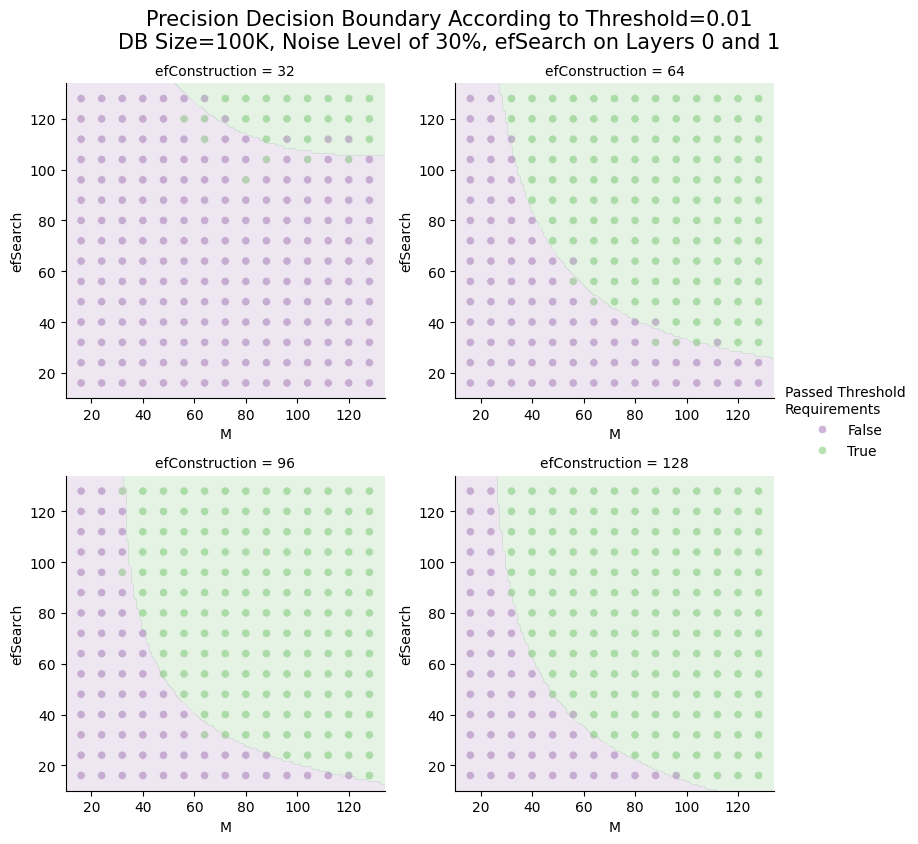

In [23]:
thres = 1 / (10**2)
results_df['Passed Threshold Requirements'] = results_df['Recall'] > (1 - thres)
facetgrid = sns.FacetGrid(results_df, col='efConstruction', col_wrap=2, height=4, sharex=False, sharey=False)
facetgrid.map_dataframe(scatterplot_results)
facetgrid.add_legend(title='Passed Threshold\nRequirements')
facetgrid.fig.suptitle(f"Precision Decision Boundary According to Threshold={thres}\nDB Size={int_to_scaled_string(max_tested_db_size)}, Noise Level of {noise_level:.0%}, efSearch on Layers 0 and 1", fontsize=15, y=1.05)
plt.show()

## Stats relation to efConstruction

In [53]:
mask = (results_df['efConstruction'] >= 64)
results_df.loc[mask, 'Insufficient Recall'] = results_df.loc[mask, 'Recall'] < 1 
results_df['Examine efConstruction'] = results_df[mask].groupby(['M' ,'efSearch'])['Insufficient Recall'].transform('any')

In [60]:
plot_df = (
    results_df[results_df['Examine efConstruction'].fillna(False)]
    .groupby(['M', 'efSearch'])['Recall']
    .agg({'min', 'max'})
    .diff(axis=1)['max']
    .rename('efConstruction Diff')
    .reset_index()
)

/var/folders/9g/pshnfl_53rv2t0zccy8bcr_m0000gn/T/ipykernel_46226/1527033325.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df[results_df['Examine efConstruction'].fillna(False)]


<Axes: xlabel='M', ylabel='efSearch'>

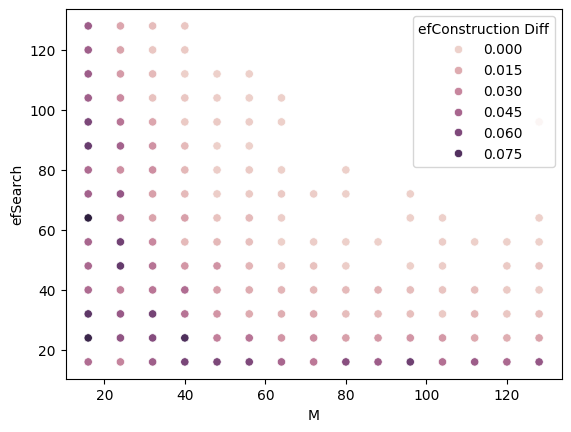

In [62]:
sns.scatterplot(plot_df, x='M', y='efSearch', hue='efConstruction Diff')

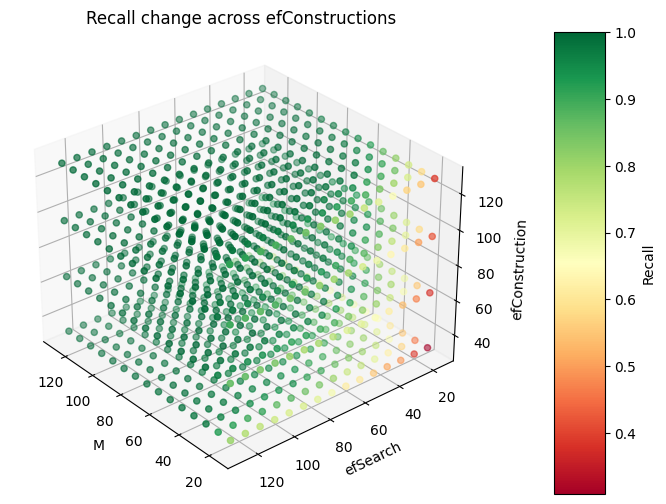

In [48]:
# Assuming results_df is a DataFrame and contains a column 'Recall'
fig = plt.figure(figsize=(8, 6))

# Create a GridSpec layout to allocate space for the color bar
gs = GridSpec(1, 2, width_ratios=[10, 1])  # Plot gets more space, color bar gets less
ax = fig.add_subplot(gs[0], projection='3d')  # Main 3D plot
cax = fig.add_subplot(gs[1])  # Color bar axis

# Normalize the Recall column for color mapping
norm = mcolors.Normalize(vmin=results_df['Recall'].min(), vmax=results_df['Recall'].max())
colormap = cm.RdYlGn  # Red to Green colormap

# Scatter plot with color coding based on 'Recall'
scatter = ax.scatter(
    results_df['M'],
    results_df['efSearch'],
    results_df['efConstruction'],
    c=results_df['Recall'],  # Use the 'Recall' column for color
    cmap=colormap  # Apply the red-yellow-green colormap
)

# Add the color bar to the specified axis
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), cax=cax)
cbar.set_label('Recall')

# Set view and labels
ax.view_init(elev=30, azim=140)
ax.set_xlabel('M')
ax.set_ylabel('efSearch')
ax.set_zlabel('efConstruction')
ax.set_title('Recall change across efConstructions')

plt.show()

In [36]:
efConstruction_stability = (
    results_df[results_df['efConstruction'] >= 64]
    .groupby(['efSearch', 'M'])['Recall']
    .std()
    .rename('Recall Standard Deviation')
    .reset_index()
)
efConstruction_stability['95% Error Bandwidth for Recall'] = efConstruction_stability['Recall Standard Deviation'] * 1.96

<Axes: xlabel='M', ylabel='efSearch'>

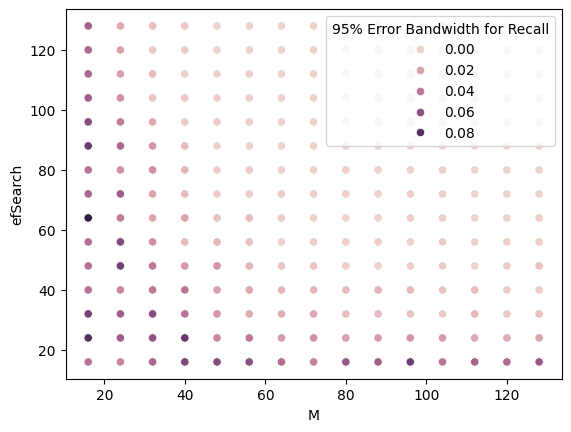

In [38]:
sns.scatterplot(efConstruction_stability, x='M', y='efSearch', hue='95% Error Bandwidth for Recall')

## Decision Boundary Stability Over efConstruction

In [43]:
def approx_func(M, a, b):
    return a + (b / M)

In [47]:
def get_decision_boundary_coefs(data, thres):
    # Step 1: Train the SVM model with a polynomial kernel of degree 2
    model = SVC(kernel='poly', degree=2)
    passed_thres = (data['Recall'] > (1 - thres)).to_numpy()
    if np.unique(passed_thres).size < 2:
        return (None, None)
    model.fit(data[['M', 'efSearch']].to_numpy(), passed_thres)

    # Step 2: Generate a grid of M and efSearch values covering the range in the data
    m_values = np.linspace(data['M'].min(), data['M'].max(), 400)
    efsearch_values = np.linspace(data['efSearch'].min(), data['efSearch'].max(), 400)
    M_grid, efSearch_grid = np.meshgrid(m_values, efsearch_values)
    grid_points = np.c_[M_grid.ravel(), efSearch_grid.ravel()]
    
    # Step 3: Compute decision function values for each point on the grid
    decision_values = model.decision_function(grid_points)
    decision_values = decision_values.reshape(M_grid.shape)

    # Step 4: Identify points near the decision boundary (where decision function ≈ 0)
    # These are points for which the model is uncertain between classes.
    boundary_points = np.abs(decision_values) < 0.01  # Adjust threshold if needed
    if boundary_points.sum() == 0:
        return (None, None)
    boundary_M = M_grid[boundary_points]
    boundary_efSearch = efSearch_grid[boundary_points]

    # Step 5: Fit the inverse model (a + b / M) to the decision boundary points
    params, covariance = curve_fit(approx_func, boundary_M, boundary_efSearch, maxfev=2000)
    
    return params

In [48]:
results_path = f'100K_precision_results.parquet'
results_df = pd.read_parquet(results_path)

In [49]:
thres_grid = np.linspace(1/10**2, 1/10**4, 100)
params_df = (
    pd.concat(
        [
            pd.DataFrame(
                data=results_df.groupby('efConstruction').apply(lambda group: get_decision_boundary_coefs(group, thres)).tolist(), 
                index=efConstructions, 
                columns=['Intercept', 'Coefficient']
            ).assign(Threshold = thres) for thres in thres_grid
        ]
    ).reset_index(names='efConstruction')
    .melt(id_vars=['efConstruction', 'Threshold'], value_vars=['Intercept', 'Coefficient'], var_name='Constant', value_name='Value')
)

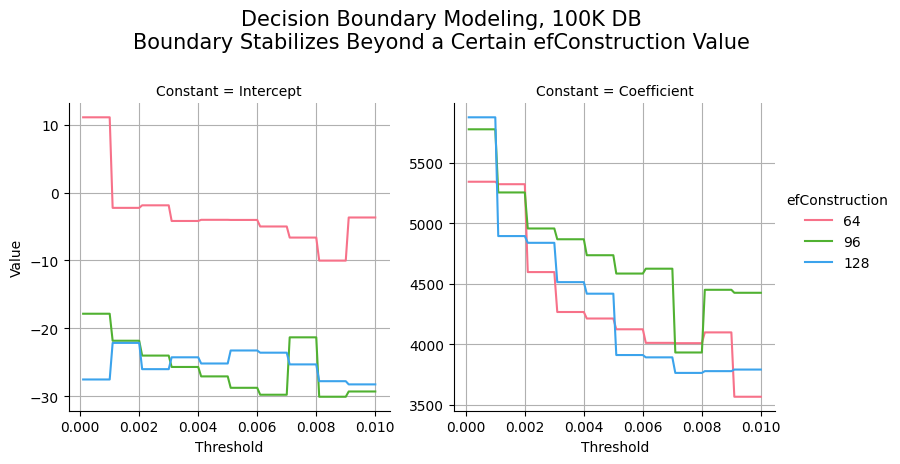

In [50]:
mask = params_df['efConstruction'] > 32
facetgrid = sns.FacetGrid(params_df[mask], col='Constant', hue='efConstruction', palette='husl', height=4, sharex=False, sharey=False)
facetgrid.map_dataframe(sns.lineplot, x='Threshold', y='Value')
facetgrid.add_legend()
[ax.grid() for ax in facetgrid.axes.flat]
facetgrid.fig.suptitle(
    f"Decision Boundary Modeling, {int_to_scaled_string(db_size)} DB\nBoundary Stabilizes Beyond a Certain efConstruction Value", 
    fontsize=15, y=1.15
)
plt.show()

## Decision Boundary Stability Over DB Size

In [28]:
efConstruction = 256
db_size_range = np.arange(50000, 250001, 5000)
M_range = np.arange(16, 193, 8)
efSearch_range = np.arange(16, 193, 8)
K = 1

In [29]:
num_experiments = 1000
noise_level = 0.3
no_search_test_size = len(M_range)
results_path = f'efConstruction{efConstruction}_db_size_stability_results.parquet'

In [30]:
synthetic_data_size = 2**22
path_masks = f'synthetic_data/{int_to_scaled_string(synthetic_data_size)}_mask_arrays.dat'
path_iris_low = 'synthetic_data/2_23_voter_arrays_90k_b090.dat'
path_iris_high = 'synthetic_data/2_23_voter_arrays_14k_b010.dat'

In [20]:
loaded_masks = load_and_reshape_masks(path_masks, db_size_range.max()).astype(bool)
loaded_irises = load_and_reshape_irises(path_iris_low, path_iris_high, db_size_range.max())

In [21]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(db_size_range.max(), *DIM), loaded_masks)

In [1]:
results_lst, avg_iteration_time = [], 0
for j, M in enumerate(M_range):
    start_time = time.time()
    iris_df['Inserted'] = False
    db = hnsw.HNSW(
        M=M, 
        efConstruction=efConstruction, 
        m_L=1/np.log(M), 
        distance_func=distance, 
        query_to_vector_func=query_to_vector
    )
    for db_size in db_size_range:
        results_lst = []
        update_db(db, iris_df, db_size)
    
        for efSearch in efSearch_range:
            indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values  
            with parallel_backend('threading'):
                results = Parallel(n_jobs=n_jobs)(
                    delayed(run_single_experiment)(db, indices[i], irises[i], noise_level, efSearch, K) for i in range(num_experiments)
                )
            results_lst.append((M, efConstruction, db_size, efSearch, np.mean(results), len(db.layers[1])))
        results_df = pd.DataFrame(results_lst, columns=['M', 'efConstruction', 'DB_Size', 'efSearch', 'Recall', 'Layer 1 Size'])
        # results_df.to_parquet(results_path)
    
    end_time = time.time() - start_time
    avg_iteration_time = update_avg_time(avg_iteration_time, j, end_time)
    print_progress(
        f'\r{(j+1)/len(M_range):.1%} Completed, '
        f'Average Iteration Time: {avg_iteration_time/3600:.1f} hours, '
        f'EOC: {(avg_iteration_time/3600)*(len(M_range)-(j+1)):.1f} hours\n', force_print=True
    )

In [22]:
results_path = f'efConstruction{efConstruction}_db_size_stability_results.parquet'
results_df = pd.read_parquet(results_path)

In [67]:
thres = 1 / (10**2)
plot_df = pd.DataFrame(
    data=results_df.groupby('DB_Size').apply(lambda group: get_decision_boundary_coefs(group, thres)).tolist(), 
    index=db_size_range, 
    columns=['Intercept', 'Coefficient']
).reset_index(names='DB Size').melt(id_vars='DB Size', value_vars=['Intercept', 'Coefficient'], var_name='Constant', value_name='Value')

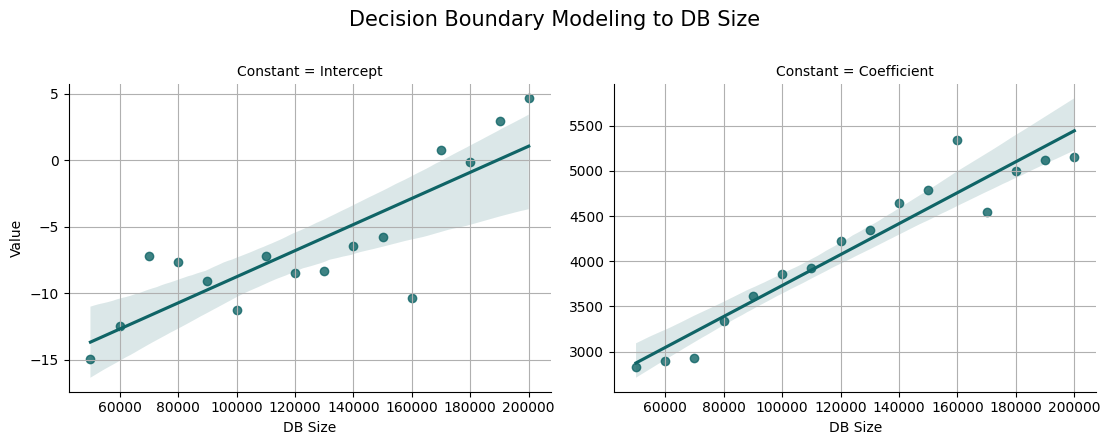

In [68]:
facetgrid = sns.FacetGrid(plot_df, col='Constant', height=4, aspect=1.4, sharex=False, sharey=False)
facetgrid.map_dataframe(sns.regplot, x='DB Size', y='Value', color='#0F6466')
[ax.grid() for ax in facetgrid.axes.flat]
facetgrid.fig.suptitle(
    f"Decision Boundary Modeling to DB Size", 
    fontsize=15, y=1.1
)
plt.show()

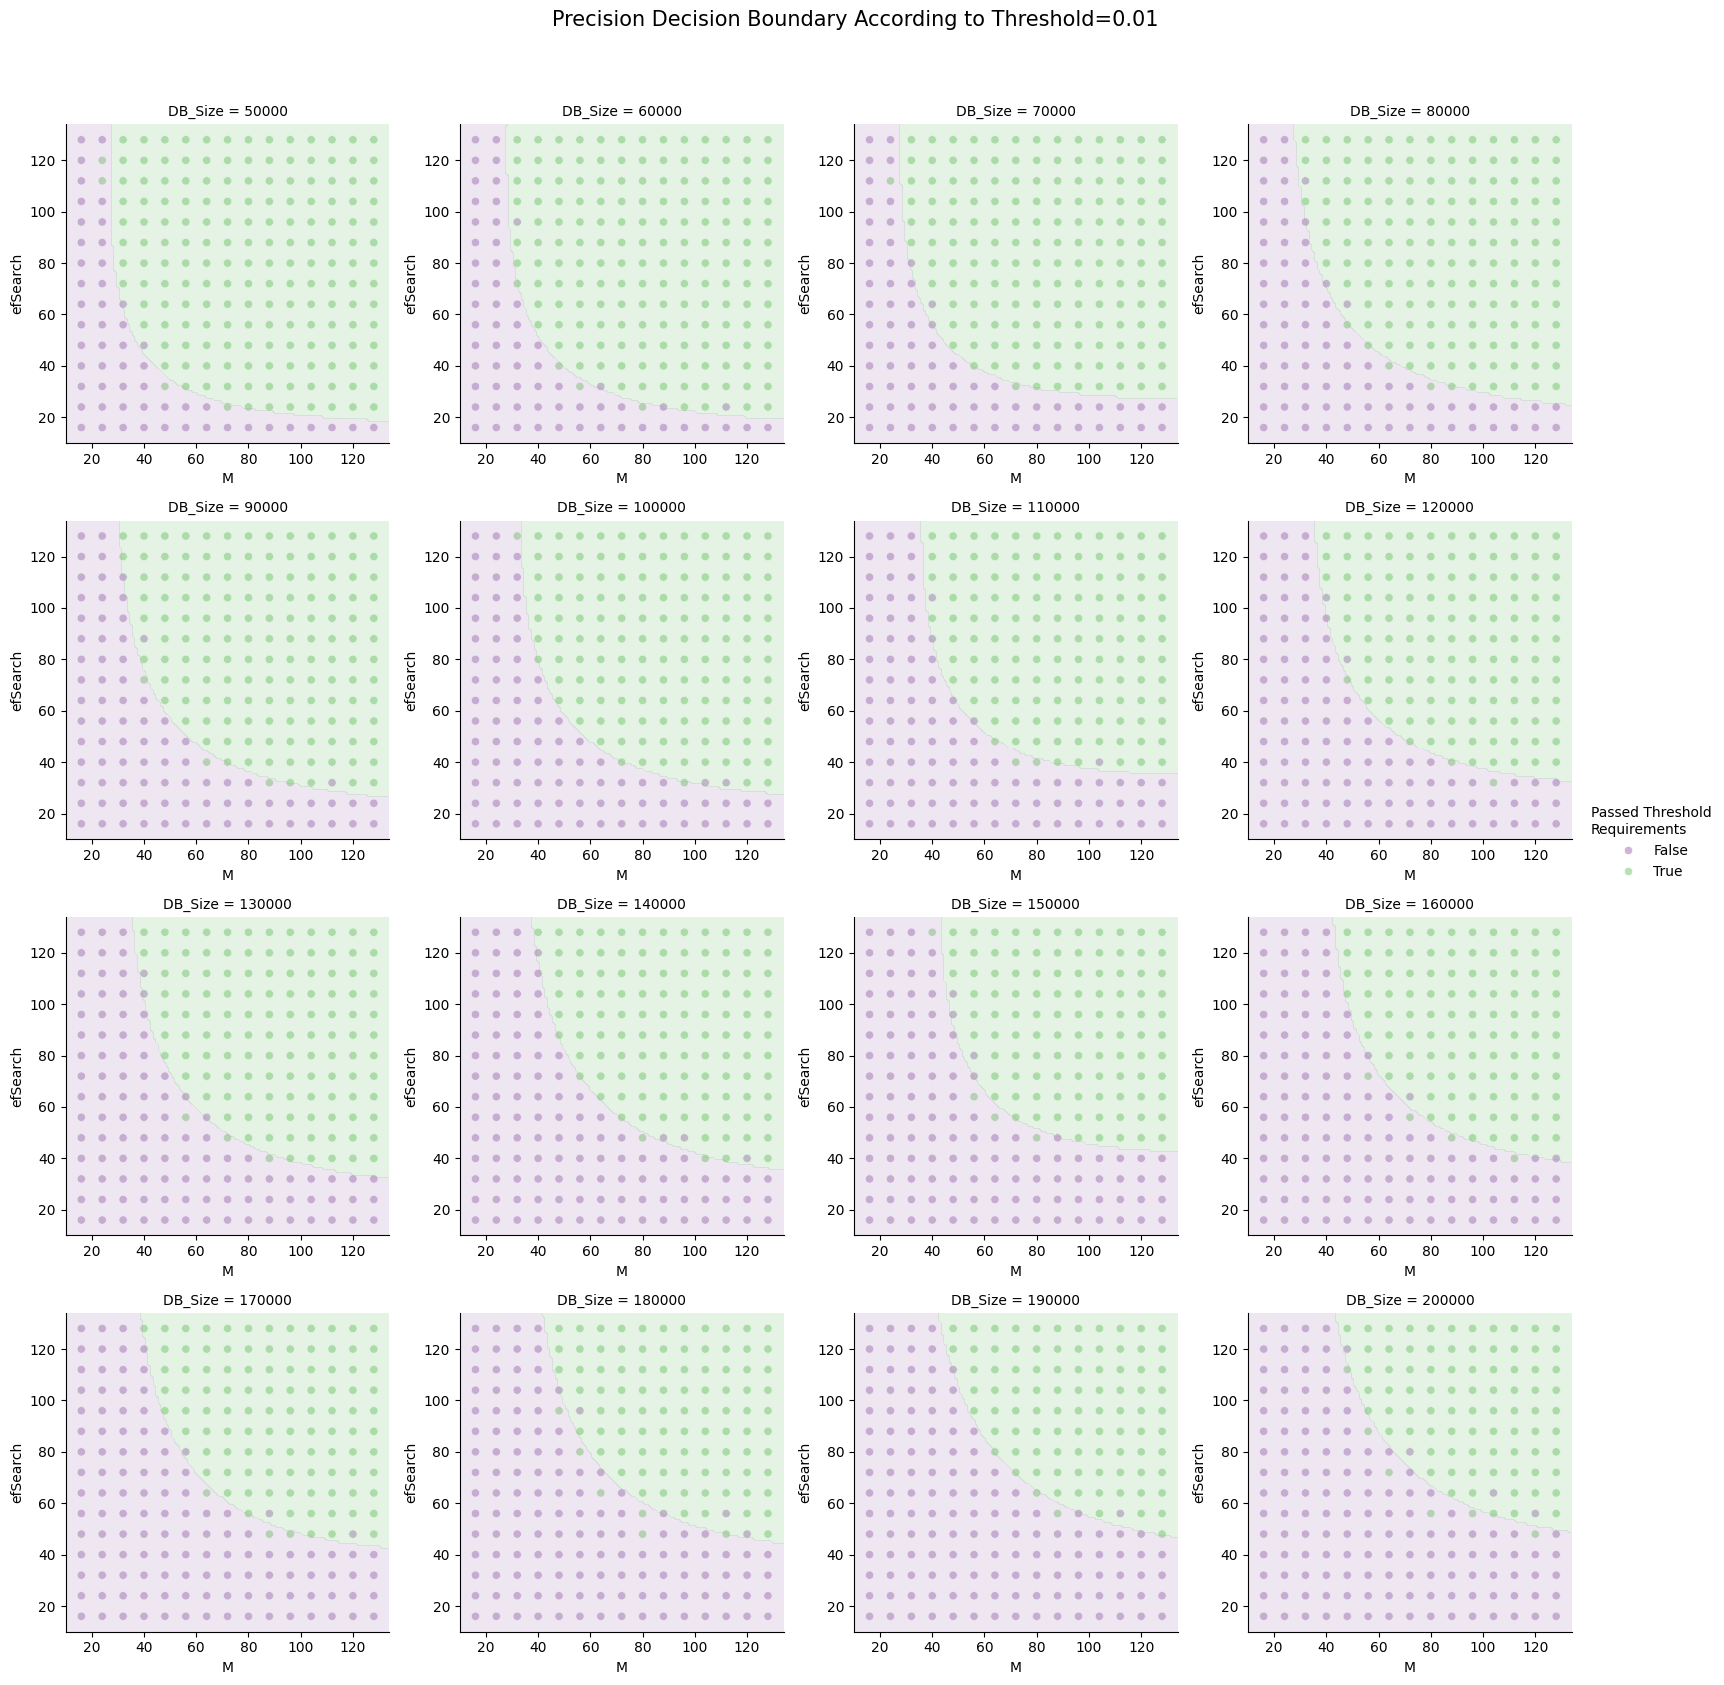

In [64]:
results_df['Passed Threshold Requirements'] = results_df['Recall'] > (1 - thres)
facetgrid = sns.FacetGrid(results_df, col='DB_Size', col_wrap=4, height=4, sharex=False, sharey=False)
facetgrid.map_dataframe(scatterplot_results)
facetgrid.add_legend(title='Passed Threshold\nRequirements')
facetgrid.fig.suptitle(f"Precision Decision Boundary According to Threshold={thres}", fontsize=15, y=1.05)
plt.show()